In [1]:
import os
import torch
import torchvision

import h5py
import deepdish as dd

import cv2
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from sklearn.metrics import roc_auc_score
from torchvision import models, transforms

import tempfile
import time
import pickle as pkl

In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/

In [2]:
# model_file = 'data/saved_models/nodule_binary.pth'
# img_path = 'data/sorted_images/Nodule/AP/00023068_003.png'
model_file = 'data/saved_models/Effusion_binary.pth'
img_path = 'data/sorted_images/Effusion/AP/00016522_023.png'

In [3]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
        self.model.fc = nn.Sequential(*[
            nn.Linear(in_features=512, out_features=1, bias=True),
            nn.Sigmoid()
        ])
        
        self.features_conv = nn.Sequential(*list(self.model.children())[:-2])
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier =  nn.Sequential(*list(self.model.children())[-2:][1:])
        
        self.gradients = None
        
    def load_weights(self):
        self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(torch.load(model_file))
    
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)

        h = x.register_hook(self.activations_hook)

        x = self.global_pool(x)
        x = x.view(1, -1)    
        x = self.classifier(x)
        
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)


In [4]:
model = ResNet()

Using cache found in /home/npp002/.cache/torch/hub/pytorch_vision_v0.6.0


In [5]:
model.load_weights()

In [6]:
transform = torchvision.transforms.ToTensor()

img = Image.open(img_path).convert('RGB')
img = transform(img)
img.shape
img = img.unsqueeze(dim=0)
img = img.cuda();

In [7]:
model = model.cuda()
model.eval()

pred = model(img)

In [8]:
print(pred)

tensor([[0.8626]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [9]:
pred.backward()

In [10]:
gradients = model.get_activations_gradient()

In [11]:
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

In [12]:
activations = model.get_activations(img).detach()

In [13]:
activations.size()

torch.Size([1, 512, 32, 32])

In [14]:
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

In [15]:
heatmap = torch.mean(activations, dim=1).squeeze()
heatmap = heatmap.cpu()

In [16]:
heatmap = np.maximum(heatmap, 0)

In [17]:
heatmap /= torch.max(heatmap)

In [18]:
heatmap[0]

tensor([0.2327, 0.2816, 0.2416, 0.2615, 0.2452, 0.2244, 0.2120, 0.2209, 0.2298,
        0.1938, 0.0610, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0666, 0.2267, 0.4351, 0.4966, 0.5078, 0.4661, 0.3843,
        0.3175, 0.2753, 0.1970, 0.1580, 0.1467])

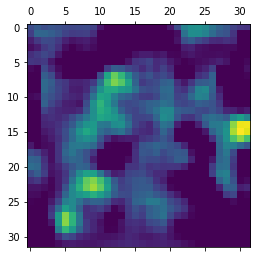

In [19]:
plt.matshow(heatmap)

In [20]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)


In [29]:
heatmap.max()

254

In [71]:
heatmap.mean()

43.34641456604004

(array([471457., 187131., 184653.,  92852.,  50478.,  31273.,  14106.,
          9852.,   3509.,   3264.]),
 array([  0. ,  25.4,  50.8,  76.2, 101.6, 127. , 152.4, 177.8, 203.2,
        228.6, 254. ]),
 <BarContainer object of 10 artists>)

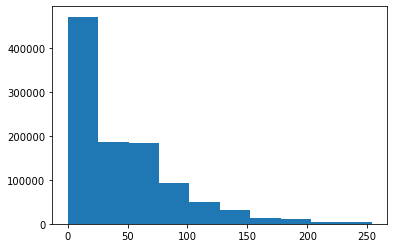

In [81]:
vis = np.resize(heatmap, (-1))
plt.hist(vis)

In [38]:
colormap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = colormap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

True

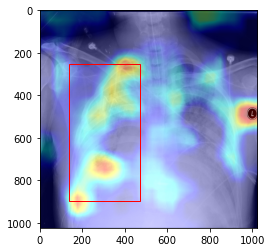

In [39]:
plt_image = cv2.imread('./map.jpg')
plt_image = cv2.cvtColor(plt_image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(plt_image)
x = 136.533333333333
y = 250.311111111111
width = 336.998941798942
height = 644.740740740741

rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [168]:
blobs = heatmap > 2.5 * heatmap.mean()

In [169]:
from skimage import measure

all_labels = measure.label(blobs)

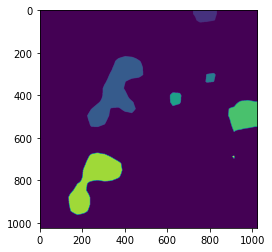

In [170]:
plt.figure()
plt.imshow(all_labels)

In [171]:
np.unique(all_labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [172]:
def get_bboxes(label_map):
    uniques = np.unique(label_map)
    boxes = {} # stored as x1, x2, y1, y2
    
    
    for u in uniques:
        low_x = 9999
        low_y = 9999
        high_x = -1
        high_y = -1
        
        for r in range(len(label_map)):
            for c in range(len(label_map[0])):
                
                cur = label_map[r][c]
                
                if cur == u:
                    low_x = min(low_x, c)
                    low_y = min(low_y, r)
                    high_x = max(high_x, c)
                    high_y = max(high_y, r)
                    
        boxes[u] = {'low_x' : low_x, 'low_y' : low_y,
                        'high_x' : high_x, 'high_y' : high_y}
        
    return boxes


In [173]:
boxdict = get_bboxes(all_labels)

0 0 1023 1023
719 0 111 58
222 217 262 331
778 296 45 44
611 387 51 62
884 424 139 147
134 671 251 290
903 685 9 12


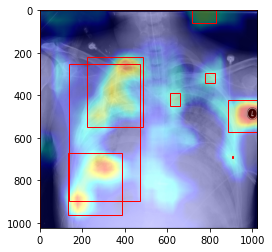

In [174]:
plt_image = cv2.imread('./map.jpg')
plt_image = cv2.cvtColor(plt_image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(plt_image)
x = 136.533333333333
y = 250.311111111111
width = 336.998941798942
height = 644.740740740741

rect_label = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect_label)

for i in range(len(boxdict)):
    x = boxdict[i]['low_x']
    y = boxdict[i]['low_y']
    width = boxdict[i]['high_x'] - x
    height = boxdict[i]['high_y'] - y
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none' )
    ax.add_patch(rect)
    print(x, y, width, height)

In [208]:
from sklearn.metrics import jaccard_score

def iobb(truedict, label_map):
    
    single_level = np.array(label_map >= 1, dtype='int')
    # convert all labels on prediction to same value of '1' for present and '0' for not present
    temp = np.zeros((1024, 1024), dtype='int')
    for y in range(1024):
        for x in range(1024):
            x_bool =  x > truedict['x'] and x < truedict['x'] + truedict['width']
            y_bool =  y > truedict['y'] and y < truedict['y'] + truedict['height']
            
            if x_bool and y_bool:
                temp[y][x] = 1
                
    plt.imshow(temp)
    plt.imshow(single_level)
    return jaccard_score(temp.flatten(), single_level.flatten())
    
    

0.2460525688117159

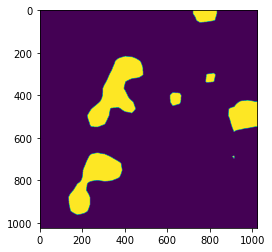

In [209]:
iobb({'x' : 137, 'y' : 250, 'width' : 337, 'height' : 645}, all_labels)

In [193]:
single_level = np.array(all_labels >= 1, dtype='int')
np.unique(single_level)

array([0, 1])

In [236]:
def iobb2(truedict, preddict):
    
    # convert all labels on prediction to same value of '1' for present and '0' for not present
    truetemp = np.zeros((1024, 1024), dtype='int')
    predtemp = np.zeros((1024, 1024), dtype='int')
    for y in range(1024):
        for x in range(1024):
            x_bool =  x > truedict['x'] and x < truedict['x'] + truedict['width']
            y_bool =  y > truedict['y'] and y < truedict['y'] + truedict['height']
            
            if x_bool and y_bool:
                truetemp[y][x] = 1
                
            for k in preddict.keys():
                x_bool =  x > preddict[k]['low_x'] and x < preddict[k]['high_x']
                y_bool =  y > preddict[k]['low_y'] and y < preddict[k]['high_y']

                if x_bool and y_bool and k != 0:
                    predtemp[y][x] = 1
                
            
                
    #plt.imshow(truetemp)
    #plt.imshow(predtemp)
    return jaccard_score(truetemp.flatten(), predtemp.flatten())
    
    

In [237]:
iobb2({'x' : 137, 'y' : 250, 'width' : 337, 'height' : 645}, boxdict)

0.46867497758366355

In [231]:
boxdict

{0: {'low_x': 0, 'low_y': 0, 'high_x': 1023, 'high_y': 1023},
 1: {'low_x': 719, 'low_y': 0, 'high_x': 830, 'high_y': 58},
 2: {'low_x': 222, 'low_y': 217, 'high_x': 484, 'high_y': 548},
 3: {'low_x': 778, 'low_y': 296, 'high_x': 823, 'high_y': 340},
 4: {'low_x': 611, 'low_y': 387, 'high_x': 662, 'high_y': 449},
 5: {'low_x': 884, 'low_y': 424, 'high_x': 1023, 'high_y': 571},
 6: {'low_x': 134, 'low_y': 671, 'high_x': 385, 'high_y': 961},
 7: {'low_x': 903, 'low_y': 685, 'high_x': 912, 'high_y': 697}}